Compiling model...
'compile' took 0.000221 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.69e-02, 5.03e-01, 2.17e-01, 1.47e-02, 1.24e-02, 6.36e-02]    [4.79e-02, 5.03e-01, 2.17e-01, 1.47e-02, 1.24e-02, 6.36e-02]    []  
100       [1.77e-02, 4.62e-02, 7.29e-03, 3.53e-04, 7.68e-04, 1.28e-01]    [1.27e-02, 4.62e-02, 7.29e-03, 3.53e-04, 7.68e-04, 1.28e-01]    []  
200       [4.84e-03, 3.48e-02, 1.42e-04, 2.57e-04, 1.71e-04, 4.05e-02]    [3.47e-03, 3.48e-02, 1.42e-04, 2.57e-04, 1.71e-04, 4.05e-02]    []  
300       [3.50e-03, 1.69e-02, 3.52e-04, 9.50e-05, 1.74e-04, 2.96e-02]    [2.42e-03, 1.69e-02, 3.52e-04, 9.50e-05, 1.74e-04, 2.96e-02]    []  
400       [2.32e-03, 1.30e-02, 1.07e-04, 6.35e-05, 1.15e-04, 1.95e-02]    [1.37e-03, 1.30e-02, 1.07e-04, 6.35e-05, 1.15e-04, 1.95e-02]    []  
500       [1.58e-03, 1.13e-02, 2.90e-04, 4.91e-05, 1.27e-04, 1.46e-02]

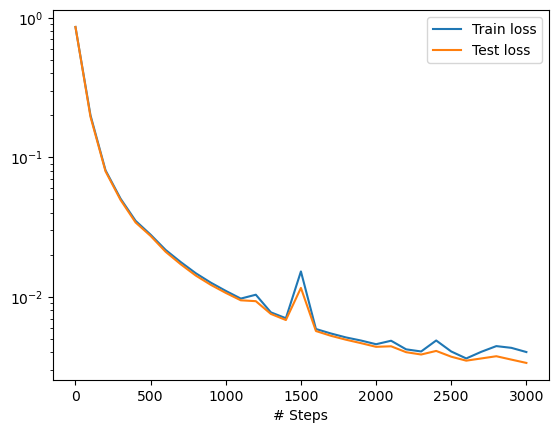

'deepxde2_model-3000.pt'

In [18]:
%matplotlib inline

import deepxde as dde
import matplotlib.pyplot as plt
import matplotlib.mlab as mlb
import matplotlib.tri as tri
import numpy as np
import torch

# 设置时空计算域
Lx0 = 2
Lx1 = 2
Lt = 1
# 设置方程参数
a = 0.5
# 设置初始条件参数
Tinit = 0
# 设置Dirichlet边界条件参数
Tbc_l = 1   # 左侧边界
Tbc_r = 0   # 右侧边界
# 设置Neumann边界条件参数
dTbc_b = 0  # 下侧边界
dTbc_t = 0  # 上侧边界

geom = dde.geometry.Rectangle([-Lx0/2, -Lx1/2], [Lx0/2, Lx1/2])
timedomain = dde.geometry.TimeDomain(0, Lt)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return dy_t - a * (dy_xx + dy_yy)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], -1)

def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

bc_l = dde.icbc.DirichletBC(geomtime, lambda x:Tbc_l, boundary_l)
bc_r = dde.icbc.DirichletBC(geomtime, lambda x:Tbc_r, boundary_r)
bc_b = dde.icbc.NeumannBC(geomtime, lambda x:dTbc_b, boundary_b)
bc_t = dde.icbc.NeumannBC(geomtime, lambda x:dTbc_t, boundary_t)

def ic_func(x):
    # return np.sin( np.pi * (x[0]/Lx0 + x[1]/Lx1) )
    return Tinit
    
ic = dde.icbc.IC(
    geomtime,
    ic_func,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_b, bc_t, ic],
    num_domain=8000,   # 12000
    num_boundary=320,   # 320
    num_initial=800,    # 800
    num_test=8000,     # 12000
)

layer_size = [3] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
# net = dde.nn.FNN([3] + [50] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=3000, display_every=100)

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# save the model
model.save('deepxde2_model')

In [28]:
model.restore('deepxde2_model-3000.pt', device="cpu")

# 所需输入: Lx0, Lx1, model
x1 = np.linspace(start=-Lx0/2, stop=Lx0/2, num=100, endpoint=True).flatten() #(100,)
x2 = np.linspace(start=-Lx1/2, stop=Lx1/2, num=100, endpoint=True).flatten() #(100,)
XX1, XX2 = np.meshgrid(x1, x2)
x_1 = XX1.flatten()
x_2 = XX2.flatten()

# Lt = 1
Nt = int(20 * Lt)

dt = Lt / Nt
for n in range(0, Nt+1):
    t = n * dt
    t_list = t*np.ones((len(x_1), 1))
    x_pred = np.concatenate([x_1[:, None], x_2[:, None], t_list], axis=1)
    y_pred = model.predict(x_pred)
    y_p = y_pred.flatten()
    data_n = np.concatenate([x_pred, y_pred], axis=1)
    if n == 0:
        data = data_n[:, :, None]
    else:
        data = np.concatenate([data, data_n[:, :, None]], axis=2)

print(x_pred.shape, y_pred.shape)
print(data.shape, data_n.shape)

(10000, 3) (10000, 1)
(10000, 4, 21) (10000, 4)


保存路径: 2DtransientRectTC2
y_min =  -0.054616235196590424 , y_max =  1.0782749652862549
data.shape[2] =  21
(10000,) (10000,) (10000,)
0 (10000,) (10000,) (10000,)
1 (10000,) (10000,) (10000,)
2 (10000,) (10000,) (10000,)
3 (10000,) (10000,) (10000,)
4 (10000,) (10000,) (10000,)
5 (10000,) (10000,) (10000,)
6 (10000,) (10000,) (10000,)
7 (10000,) (10000,) (10000,)
8 (10000,) (10000,) (10000,)
9 (10000,) (10000,) (10000,)
10 (10000,) (10000,) (10000,)
11 (10000,) (10000,) (10000,)
12 (10000,) (10000,) (10000,)
13 (10000,) (10000,) (10000,)
14 (10000,) (10000,) (10000,)
15 (10000,) (10000,) (10000,)
16 (10000,) (10000,) (10000,)
17 (10000,) (10000,) (10000,)
18 (10000,) (10000,) (10000,)
19 (10000,) (10000,) (10000,)
20 (10000,) (10000,) (10000,)
(10000,) (10000,) (10000,)


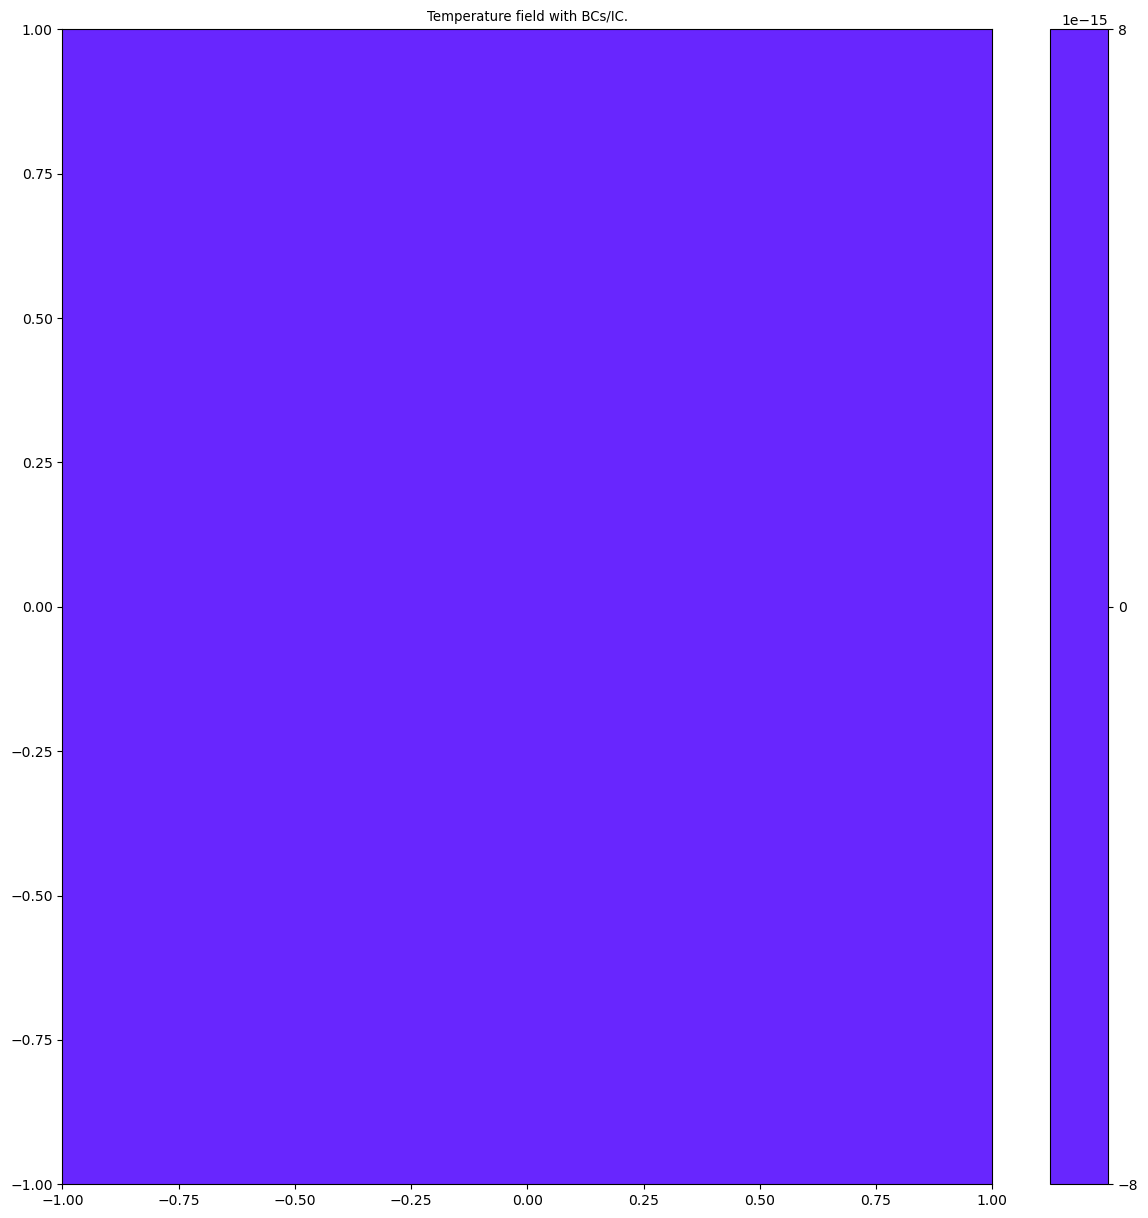

In [23]:
# 所需输入: data, dt, Nt
from matplotlib.animation import FuncAnimation
import os
work_path = os.path.join('2DtransientRectTC2',)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)
print("保存路径: " + work_path)

# 获得y的最大值和最小值
y_min = data.min(axis=(0,2,))[3]
y_max = data.max(axis=(0,2,))[3]
print("y_min = ", y_min, ", y_max = ", y_max)

# 设置colorbar显示的级别
levels = np.arange(y_min, y_max+(y_max-y_min)/30, (y_max-y_min)/30)

fig = plt.figure(100, figsize=(15, 15))

def init():
    plt.clf()
    x1_t, x2_t = data[:, 0:1, 0], data[:, 1:2, 0]
    y_p_t = 0 * np.ones((len(x1_t), 1))
    x1_t, x2_t, y_p_t = x1_t.flatten(), x2_t.flatten(), y_p_t.flatten()
    print(x1_t.shape, x1_t.shape, y_p_t.shape)

    plt.subplot(1,1,1)
    plt.tricontourf(x1_t, x2_t, y_p_t, levels=30, cmap="rainbow")
    plt.clim(vmin=y_min, vmax=y_max)
    cb0 = plt.colorbar()
    plt.title("Temperature field with BCs/IC.", fontsize = 9.5)
    plt.savefig(work_path + '//' + 'animation_BCsIC' + '.jpg')

def anim_update(t_id):
    plt.clf()
    x1_t, x2_t, y_p_t = data[:, 0:1, t_id], data[:, 1:2, t_id], data[:, 3:4, t_id]
    x1_t, x2_t, y_p_t = x1_t.flatten(), x2_t.flatten(), y_p_t.flatten()
    print(t_id, x1_t.shape, x1_t.shape, y_p_t.shape)
    
    plt.subplot(1,1,1)
    plt.tricontourf(x1_t, x2_t, y_p_t, levels=30, cmap="rainbow")
    plt.clim(vmin=y_min, vmax=y_max)
    cb0 = plt.colorbar()
    # plt.rcParams['font.family'] = 'Times New Roman'
    # plt.rcParams['font.size'] = 9.5
    plt.xlabel('$x (m)$')
    plt.ylabel('$y (m)$')
    plt.title("Temperature field at t = " + str(t_id * dt) + " s.", fontsize = 9.5)
    plt.savefig(work_path + '//' + 'animation_' + str(t_id) + '.jpg')

print("data.shape[2] = ", data.shape[2])

# anim_update(10)
# init()
anim =FuncAnimation(fig, anim_update, frames=np.arange(0, data.shape[2]).astype(np.int64), interval=200, init_func=init)
# anim =FuncAnimation(fig, anim_update, frames=np.arange(0, data.shape[2]).astype(np.int64), interval=200)
anim.save(work_path + "//" + "animation-" + str(Nt+1) + ".gif", writer="pillow", dpi=300)

In [29]:
y_p_t = data[:, 3:4, ]
u = y_p_t[:, 0, :]
np.save('../../data/heat_xyt_less', u.reshape((100, 100, -1)))
np.save('../../data/heat_x_less', x1)
np.save('../../data/heat_y_less', x2)
# np.save('../../data/heat_t', data[:, 2:3, ][0, 0, :])  # heat_t不变，还是21个时间步，不用再存一遍

In [30]:
def load_ref_data(ref_data, timepde=None):  # if pde is a timepde, then provide timepde=(t_start, t_end)
    
    d = (3, 1)  # Hardcoding the value of d

    if timepde is not None:  # transform ref_data
        time_starts, time_ends = timepde
        data = ref_data
        num_tsample = (data.shape[1] - (d[0] - 1)) // d[1]
        assert num_tsample * d[1] == data.shape[1] - (d[0] - 1)
        t = np.linspace(time_starts, time_ends, num_tsample)
        t, x0 = np.meshgrid(t, data[:, 0])  # add the first input dimension that is not time
        list_x = [x0.reshape(-1)]  # x0.reshape(-1) gives [e1,e1,...,e1, e2,e2,...,e2, ...] each element repeats num_tsample times (adjacent)
        for i in range(1, d[0] - 1):  # add other input dimensions that is not time
            list_x.append(np.stack([data[:, i] for _ in range(num_tsample)]).T.reshape(-1))  # each element repeats num_tsample times (adjacent)
        list_x.append(t.reshape(-1))  # t is the last input dimension. (Other) input dimension order should be in accordance with .dat file
        for i in range(d[1]):
            list_x.append(data[:, d[0] - 1 + i::d[1]].reshape(-1))
        ref_data = np.stack(list_x).T

    ref_x = ref_data[:, :d[0]]
    ref_y = ref_data[:, d[0]:]

    return ref_x, ref_y

In [31]:
coordinate = np.concatenate((x_1[:, None], x_2[:, None]), axis=-1)
ref_data = np.concatenate((coordinate, u), axis=-1)
out_x, out_y = load_ref_data(ref_data=ref_data, timepde=(0,1))
np.save('../../data/heat_in_less', out_x)
np.save('../../data/heat_out_less', out_y)

In [32]:
net_input = np.load('../../data/heat_in_less.npy')  # (210000,3)
net_input_grad = torch.from_numpy(net_input).requires_grad_()
net_output_grad = model.net(net_input_grad.float())

def cal_grad(x, y):
    ut = dde.grad.jacobian(y, x, i=0, j=2)
    ux = dde.grad.jacobian(y, x, i=0, j=0)
    uy = dde.grad.jacobian(y, x, i=0, j=1)
    uxx = dde.grad.hessian(y, x, i=0, j=0)
    uyy = dde.grad.hessian(y, x, i=1, j=1)
    return ut, ux, uy, uxx, uyy

ut, ux, uy, uxx, uyy = cal_grad(net_input_grad, net_output_grad)
ut, ux, uy, uxx, uyy, ut.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [17]:
data_npy = ['heat_xyt_less', 'heat_x_less', 'heat_y_less', 'heat_t', 'heat_in_less', 'heat_out_less', 'heat_ut_less', 'heat_ux_less', 'heat_uy_less', 'heat_uxx_less', 'heat_uyy_less']
for npy in data_npy:
    print(npy, np.load('../../data/' + npy + '.npy').shape)

heat_xyt_less (100, 100, 21)
heat_x_less (100,)
heat_y_less (100,)
heat_t (21,)
heat_in_less (210000, 3)
heat_out_less (210000, 1)
